In [1]:
%load_ext autoreload
%autoreload 2

import os, json
import nibabel as nb

from keras import metrics 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LocallyConnected1D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras.utils.vis_utils import plot_model

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import hrf_estimation
import scipy.signal as signal
import scipy.stats as stats

from joblib import Parallel, delayed

%matplotlib inline

Using TensorFlow backend.
/home/knapen/software/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/__init__.py:908: MatplotlibDeprecationWarning: The backend.qt4 rcParam was deprecated in version 2.2.  In order to force the use of a specific Qt binding, either import that binding first, or set the QT_API environment variable.
  mplDeprecation)
/home/knapen/software/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/__init__.py:908: MatplotlibDeprecationWarning: The backend.qt4 rcParam was deprecated in version 2.2.  In order to force the use of a specific Qt binding, either import that binding first, or set the QT_API environment variable.
  mplDeprecation)


In [2]:
# os.chdir('/Users/knapen/projects/prfpy/test/develop/')
# requires pfpy be installed - preferably with python setup.py develop
from prfpy.rf import *
from prfpy.timecourse import *
from prfpy.stimulus import PRFStimulus2D
from prfpy.grid import Iso2DGaussianGridder
from prfpy.fit import Iso2DGaussianFitter

In [3]:
x, y = np.meshgrid(np.linspace(-5,5,200), np.linspace(-5,5,200))
compl = x + y * 1j
ecc = np.abs(compl)
polar = np.angle(compl)

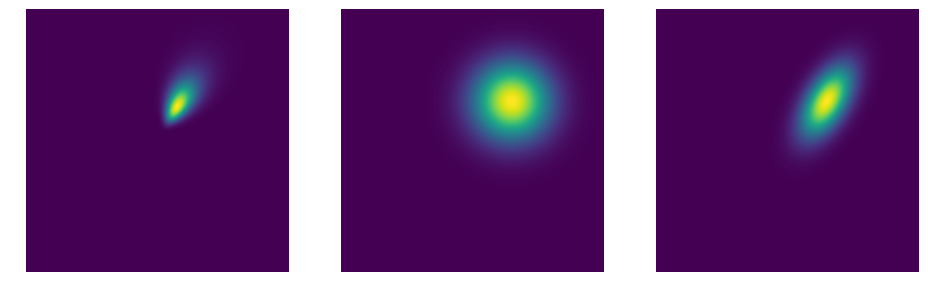

In [4]:
f, ss = plt.subplots(1,3,figsize=(16,6))
ss[0].imshow(gauss2D_logpolar(ecc, polar, mu=(1.5, np.pi/3), sigma=0.38, kappa=30))
ss[0].axis('off')
ss[1].imshow(gauss2D_iso_cart(x, y, mu=(1.5, 1.5), sigma=1.0))
ss[1].axis('off')
ss[2].imshow(gauss2D_rot_cart(x, y, mu=(1.5, 1.5), sigma=1.0, theta=np.pi/3, ar=2.0))
ss[2].axis('off')
plt.savefig("../../docs/imgs/rf_shapes.png")

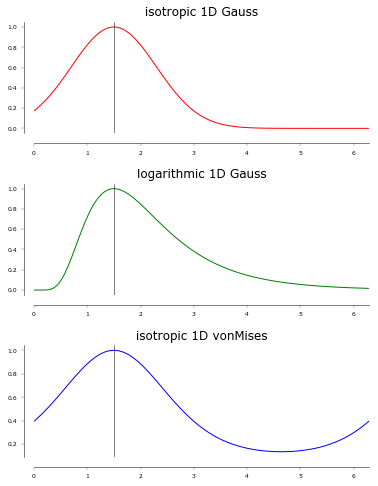

In [5]:
x1D = np.linspace(0,2*np.pi, 100)
m = 1.5
f, ss = plt.subplots(3,1,figsize=(6,8))
ss[0].plot(x1D, gauss1D_cart(x1D, m, 0.8), 'r')
ss[0].set_title('isotropic 1D Gauss')
ss[0].set_xlim([0,2*np.pi])
ss[0].axvline(m, c='k', lw=0.5)
ss[1].plot(x1D, gauss1D_log(x1D, m, 0.5), 'g')
ss[1].set_title('logarithmic 1D Gauss')
ss[1].set_xlim([0,2*np.pi])
ss[1].axvline(m, c='k', lw=0.5)
ss[2].plot(x1D, vonMises1D(x1D, m, 1), 'b')
ss[2].set_title('isotropic 1D vonMises')
ss[2].set_xlim([0,2*np.pi])
ss[2].axvline(m, c='k', lw=0.5)
f.subplots_adjust(hspace=0.45)
sns.despine(offset=10)
plt.savefig("../../docs/imgs/rf_shapes_1D.png")

In [28]:
stim_dm = np.load('../data/dm.npy').T # transpose for final dimension time
prf_stim = PRFStimulus2D(screen_size_cm=70, 
                         screen_distance_cm=125, 
                         design_matrix=stim_dm, 
                         TR=1.6)

grid_nr = 5
max_ecc_size = 20
sizes, eccs, polars = max_ecc_size * np.linspace(0.25,1,grid_nr)**2, \
                    max_ecc_size * np.linspace(0.1,1,grid_nr)**2, \
                        np.linspace(0, 2*np.pi, grid_nr)

gg = Iso2DGaussianGridder(stimulus=prf_stim)

simulated_data = gg.return_single_prediction(mu_x=1.23,
                                            mu_y=-2.4,
                                            size=1.12, 
                                            n=0.87,
                                            beta=3.21,
                                            baseline=-0.76)

gf = Iso2DGaussianFitter(data=simulated_data, gridder=gg, n_jobs=1)


In [37]:
gf.grid_fit(ecc_grid=eccs,
                 polar_grid=polars,
                 size_grid=sizes)
gf.iterative_fit(rsq_threshold=0)

100%|██████████| 125/125 [00:00<00:00, 2856.91it/s]

[12.0125]


TypeError: return_single_prediction() missing 2 required positional arguments: 'mu_y' and 'size'

In [14]:
gg.predictions.shape

(125, 167)

In [7]:
# %%time
# prf_stim.grid_rfs = np.array(
#                         Parallel(n_jobs=8)(
#                             delayed(gauss2D_iso_cart)(
#                               prf_stim.x_coordinates, prf_stim.y_coordinates, mu=mu, sigma=s) 
#                                 for mu, s in zip(mus.reshape((-1,2)), sizes.ravel()
#                                           )
#                         )
#                     )

In [14]:
%%time
prf_stim.grid_rfs = gauss2D_iso_cart(
                prf_stim.x_coordinates[...,np.newaxis], 
                prf_stim.y_coordinates[...,np.newaxis], 
                mu=mus.reshape((-1,2)).T, 
                sigma=sizes.ravel()).T

CPU times: user 14.6 s, sys: 935 ms, total: 15.6 s
Wall time: 15.5 s


In [15]:
%%time
prf_stim.conv_dm = convolve_stimulus_dm(stim_dm, hrf=hrf_estimation.hrf.spmt(np.arange(0,40,prf_stim.TR)))
prf_stim.predictions = stimulus_through_prf(prf_stim.grid_rfs, prf_stim.conv_dm)

CPU times: user 23.2 s, sys: 2.44 s, total: 25.7 s
Wall time: 7.92 s


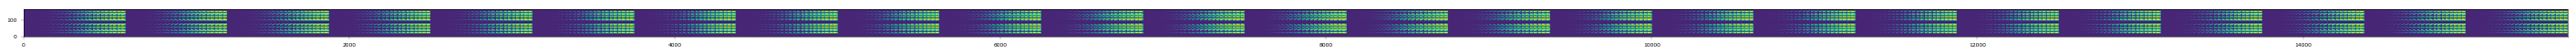

In [16]:
plt.figure(figsize=(50,5))
plt.imshow(prf_stim.predictions.T)

In [13]:
prf_stim.grid_rfs.shape

(168, 168, 15625)

In [ ]:
import sklearn
sklearn.__version__

In [ ]:
a = generate_random_cosine_drifts(dimensions=(1000, 120),
                                  amplitude_ranges=[[0,0]])

In [ ]:
a[0].sum()

In [93]:
from prfpy.grid import Iso2DGaussianGridder
ri2gg = Iso2DGaussianGridder(prf_stim)

In [94]:
%%time
n_grid_steps = 12
ri2gg.create_timecourses(ecc_grid=np.logspace(np.log10(0.1),np.log10(10),n_grid_steps),
                           polar_grid=np.linspace(0.0,2*np.pi,n_grid_steps),
                           size_grid=np.logspace(np.log10(0.1),np.log10(10),n_grid_steps),
                           n_grid=np.linspace(0.1,1,5),
                           filter_predictions=True)

CPU times: user 34.5 s, sys: 2.48 s, total: 37 s
Wall time: 26.1 s


In [91]:
ri2gg.create_drifts_and_noise(drift_ranges=[[300, 500], [-50,50], [-25,25]],
                               noise_ar=[(1.0, .4),(1, .4)],
                               noise_amplitude=1.0)

(167, 8640)


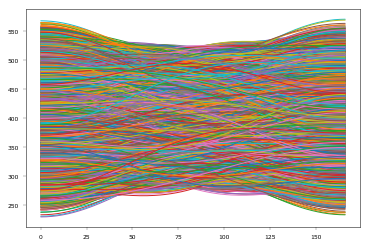

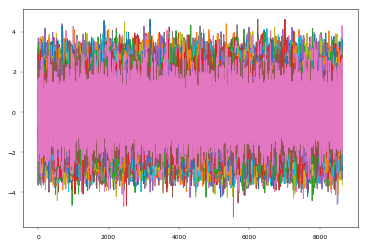

In [84]:
print(ri2gg.random_drifts[0].shape)
plt.plot(ri2gg.random_drifts[0]);
plt.figure()
plt.plot(ri2gg.random_noise);

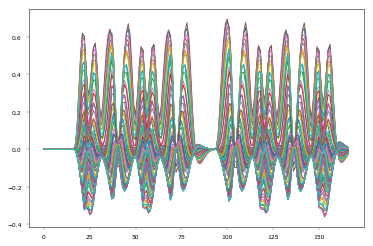

In [98]:
plt.plot(ri2gg.predictions[:100].T);

In [86]:
ri2gg.stimulus_times_prfs()

ValueError: operands could not be broadcast together with shapes (8640,167) (8640,) (8640,167) 

In [115]:
N = 10
PHI = 0.4
SAMPLES = 30
means = np.zeros(N)
cov = PHI ** sp.linalg.toeplitz(np.arange(N))

# Draw from multivariate normal with AR1 covariance
noise = np.random.multivariate_normal(means, cov, SAMPLES)

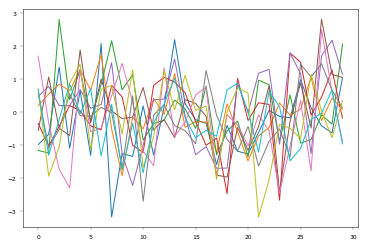

In [116]:
plt.plot(noise);

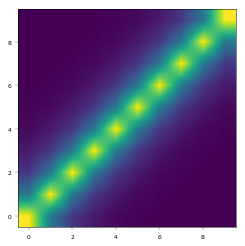

In [112]:
plt.imshow(cov)